#                      **DEEPFAKE DETECTION**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* Converting Video into Frames





In [14]:
import cv2
import os

# Function to extract frames from a video at a specified interval and save them in a folder
def extract_frames(video_path, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    # Get video properties
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if(total_frames<30):
      return 0
    frame_interval = total_frames//30
    # Initialize frame count and file index
    frame_count = 0
    file_index = 0
    print(f"Video Frame Rate: {frame_rate} fps")
    print(f"Total Frames in Video: {total_frames}")
    print(frame_interval)
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            if frame_count % frame_interval == 0 and file_index<30:
                frame_file = os.path.join(output_folder, f"frame_{file_index:04d}.jpg")
                cv2.imwrite(frame_file, frame)
                file_index += 1
            frame_count += 1
        else:
            break

    # Release the video capture object and close any open windows
    cap.release()
    cv2.destroyAllWindows()
    print(f"Extracted {file_index} frames from {video_path} to {output_folder}")
    return file_index


* Feature(Eye and Mouth) extraction from each frame


In [15]:
def maxi(x,y):
  if x-y < 0:
    return 0
  else:
    return x-y

In [16]:
import dlib
import cv2
from matplotlib import pyplot as plt
from PIL import Image
import torch
import torchvision
from torchvision import transforms

# Normalization part
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def Extract_eye_mouth(frames_taken, video_path):
    eye_array = []
    mouth_array=[]
    final_array=[]

    if not os.path.exists("eyes1"):
            os.makedirs("eyes1")
    if not os.path.exists("mouth1"):
            os.makedirs("mouth1")
    if not os.path.exists("finalFrames"):
      os.makedirs("finalFrames")


    # Load the pre-trained face detector
    detector = dlib.get_frontal_face_detector()
    # Load the pre-trained facial landmark predictor
    predictor = dlib.shape_predictor("/content/drive/MyDrive/shape_predictor_68_face_landmarks.dat")
    # Load the input image
    file_index = 0
    for i in range(frames_taken):
        # Detect faces in the grayscale image
        image = cv2.imread(f'/content/frames1/frame_{i:04d}.jpg')
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)
        if len(faces) == 0:
            continue
        # Loop over the faces found

        width = image.shape[1]
        height = image.shape[0]

        for face in faces:
            # Determine the facial landmarks for the face region
            landmarks = predictor(gray, face)
            # Extract the coordinates of the eyes and mouth
            left_eye = (landmarks.part(36).x, landmarks.part(36).y)
            right_eye = (landmarks.part(45).x, landmarks.part(45).y)
            mouth_left = (landmarks.part(48).x, landmarks.part(48).y)
            mouth_right = (landmarks.part(54).x, landmarks.part(54).y)
            dis=(landmarks.part(48).y-landmarks.part(36).y)//4

            # detect eye and save in file
            a, b = left_eye
            c, d = right_eye
            slope = (d - b) / (c - a)
            try:
              if slope > 0:
                  img = image[maxi(b, dis) : d + dis, maxi(a, dis): min(c + dis, width)]
              else:
                  img = image[maxi(d, dis) : b + dis , maxi(a, dis) : min(c + dis, width)]
              frame_file = os.path.join("eyes1", f"eyeframes_{file_index:04d}.jpg")
              eye_resized = (cv2.resize(img, (100,50)))
            except:
              continue

            cv2.imwrite(frame_file, eye_resized)
            #detect mouth and save in file
            a, b = mouth_left
            c, d = mouth_right
            slope = (d - b) / (c - a)

            try:
              if slope > 0:
                  img = image[b - dis: min(d + dis, height), maxi(a, dis): min(c+dis, width)]
              else:
                  img = image[d-dis : min(b + dis, height) , maxi(a, dis) : min(c+dis, width)]

              frame_file = os.path.join("mouth1", f"mouthframes_{file_index:04d}.jpg")
              mouth_resized = (cv2.resize(img, (100,50)))
            except:
              continue

            cv2.imwrite(frame_file,mouth_resized)
            image1 = eye_resized
            image2 = mouth_resized
            max_width = max(image1.shape[1], image2.shape[1])
            # Create a new array with the maximum width and total height
            total_height = image1.shape[0] + image2.shape[0]
            merged_image = np.zeros((total_height, max_width, 3), dtype=np.uint8)
            # Paste the first image at the top
            merged_image[:image1.shape[0], :image1.shape[1]] = image1
            # Paste the second image below the first one
            merged_image[image1.shape[0]:, :image2.shape[1]] = image2
            frame_file = os.path.join("finalFrames", f"finalFrames_{file_index:04d}.jpg")
            cv2.imwrite(frame_file,merged_image)
            image = Image.fromarray(merged_image)

            #resize using transformer
            transform1 = transforms.Resize((112, 112))
            img1 = transform1(image)


            #convert into tensor
            transform2 = transforms.ToTensor()
            img2 = transform2(img1)

            #Normalize image
            transfrom3 = transforms.Normalize(mean, std)
            img3 = transfrom3(img2)

            final_array.append(img3)

            file_index+=1

    if(len(final_array)==0):
      return [], 0

    if "Fake" in video_path:
      label = 0
    else:
      label = 1
    final_array = torch.stack(final_array)
    final_array = final_array[:10]
    return final_array, label

In [12]:
def preprocessing(video_path, output_folder):
    frames_taken = extract_frames(video_path, output_folder)
    if(frames_taken == 0):
      return []

    final_array, label = Extract_eye_mouth(frames_taken, video_path)

    if(len(final_array)==0):
      return []

    # Print the length of final_array
    print(f"Length of final_array: {len(final_array)}")

    # Check for None values in final_array
    if any(tensor is None for tensor in final_array):
        print("Error: final_array contains None values")

    return final_array, label

# **Model Training**


In [5]:
import torch
from torch import nn
from torchvision import models
import numpy as np

class Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained = True)
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))

In [6]:
import torch
from torch.autograd import Variable
import time
import os
import sys
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        _,outputs = model(inputs)
        loss  = criterion(outputs,targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    torch.save(model.state_dict(),'/content/checkpoint.pt')
    return losses.avg,accuracies.avg


def test(model, test_loader, criterion):
    model.eval()  # Set model to evaluation mode

    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Lists to store true and predicted labels for later evaluation metrics calculation
    y_true = []
    y_pred = []

    # Iterate through test dataset
    for inputs, targets in test_loader:
        inputs = inputs.cuda() if torch.cuda.is_available() else inputs
        targets = targets.cuda() if torch.cuda.is_available() else targets
        # Forward pass
        with torch.no_grad():
            _, outputs = model(inputs)  # Extracting the classification output from the tuple

        # Compute loss (optional)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

        # Compute predictions
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == targets).sum().item()
        total_samples += targets.size(0)

        # Append true and predicted labels for evaluation metrics calculation
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

    # Compute accuracy
    accuracy = correct_predictions / total_samples

    # Compute other evaluation metrics
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Return evaluation metrics
    return accuracy, test_loss / len(test_loader), precision, recall, f1,y_true,y_pred


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)
    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / batch_size

In [ ]:
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten
import random
from torch.utils.data import DataLoader
import pickle
output_folder = "frames1"


# Load the videos and extract frames
video_paths = []  # List of video file paths
frames_eye_all = []
frames_mouth_all = []
labels_all = []
video_label=[]
total_data = []

for file in os.listdir("/content/drive/MyDrive/Real_videos"):
  if file == ".ipynb_checkpoints":
    break
  video_paths.append("/content/drive/MyDrive/Real_videos/"+file)

for file in os.listdir("/content/drive/MyDrive/Fake_videos"):
  if file == ".ipynb_checkpoints":
    break
  video_paths.append("/content/drive/MyDrive/Fake_videos/"+file)


i=0

video_paths1 =video_paths[:1200]
# Assuming video_paths contains paths to all videos
for video_path in video_paths1:
    i=i+1
    final_frames = preprocessing(video_path, output_folder)
    print("video number - ", i)
    if(len(final_frames)==0):
      continue
    total_data.append(final_frames)


Streaming output truncated to the last 5000 lines.
Extracted 30 frames from /content/drive/MyDrive/Real_videos/id46_0003.mp4 to frames1
Length of final_array: 10
video number -  367
Video Frame Rate: 30.0 fps
Total Frames in Video: 342
11
Extracted 30 frames from /content/drive/MyDrive/Real_videos/id46_0005.mp4 to frames1
Length of final_array: 10
video number -  368
Video Frame Rate: 30.0 fps
Total Frames in Video: 313
10
Extracted 30 frames from /content/drive/MyDrive/Real_videos/id45_0003.mp4 to frames1
Length of final_array: 10
video number -  369
Video Frame Rate: 30.0 fps
Total Frames in Video: 334
11
Extracted 30 frames from /content/drive/MyDrive/Real_videos/id46_0006.mp4 to frames1
Length of final_array: 10
video number -  370
Video Frame Rate: 30.0 fps
Total Frames in Video: 328
10
Extracted 30 frames from /content/drive/MyDrive/Real_videos/id45_0009.mp4 to frames1
Length of final_array: 10
video number -  371
Video Frame Rate: 30.0 fps
Total Frames in Video: 310
10
Extracted

In [ ]:
print(len(total_data))

1198


In [ ]:
import pickle

# Specify the full path to the pickle file
pickle_file_path = "/content/drive/MyDrive/total_data.pkl"

# Store total_data into file
with open(pickle_file_path, 'wb') as f:
    pickle.dump(total_data, f)


print(len(total_data))

1198


In [3]:
import random
from torch.utils.data import DataLoader
import pickle

total_data_file = "/content/drive/MyDrive/total_data.pkl"

with open(total_data_file, 'rb') as f:
  data=pickle.load(f)

random.shuffle(data)

# Split total_data into train and test sets
train_data = data[:900]
test_data = data[900:]



train_loader = DataLoader(train_data,batch_size = 3,shuffle = False,num_workers = 2)
test_loader  = DataLoader(test_data, batch_size=1, shuffle=False)

In [4]:
print(len(data))

1198


In [7]:

model = Model(2).cuda()
a,b = model(torch.from_numpy(np.empty((1,20,3,112,112))).type(torch.cuda.FloatTensor))

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import statistics

# Learning rate
lr = 3e-5
# Number of epochs
num_epochs = 12

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss().cuda()

train_loss_avg = []
train_accuracy = []
test_loss_avg = []
test_accuracy = []

# Training loop
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_epoch(epoch, num_epochs, train_loader, model, criterion, optimizer)
    print(f'Epoch {epoch}/{num_epochs} Loss: {train_loss}  Accuracy: {train_acc}')
    train_loss_avg.append(train_loss)
    train_accuracy.append(train_acc)

print()
print(f'Train accuracy: {statistics.mean(train_accuracy)}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:02<00:00, 46.1MB/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithre

Epoch 1/12 Loss: 0.5521181888629992  Accuracy: 74.11111111111111
Epoch 2/12 Loss: 0.4161018744638811  Accuracy: 85.22222222222223
Epoch 3/12 Loss: 0.35388794334217283  Accuracy: 89.33333333333333
Epoch 4/12 Loss: 0.2776399788730002  Accuracy: 93.66666666666667
Epoch 5/12 Loss: 0.21679826885044653  Accuracy: 96.0
Epoch 6/12 Loss: 0.1526335633166021  Accuracy: 99.22222222222223
Epoch 7/12 Loss: 0.12835687567799747  Accuracy: 99.33333333333333
Epoch 8/12 Loss: 0.154336098074034  Accuracy: 99.0
Epoch 9/12 Loss: 0.23936367748940635  Accuracy: 96.33333333333333
Epoch 10/12 Loss: 0.13513223573309613  Accuracy: 98.88888888888889
Epoch 11/12 Loss: 0.11684216035633578  Accuracy: 99.88888888888889
Epoch 12/12 Loss: 0.11330928878595989  Accuracy: 100.0

Train accuracy: 94.25


In [8]:
# Testing loop
test_acc, test_loss, precision, recall, f1,y_true,y_pred = test(model, test_loader, criterion)
test_accuracy.append(test_acc)
test_loss_avg.append(test_loss)
print(f'Test accuracy: {statistics.mean(test_accuracy)*100}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

Test accuracy: 94.96644295302013
Precision: 0.9496892194207632
Recall: 0.9496644295302014
F1-score: 0.9496661301519863


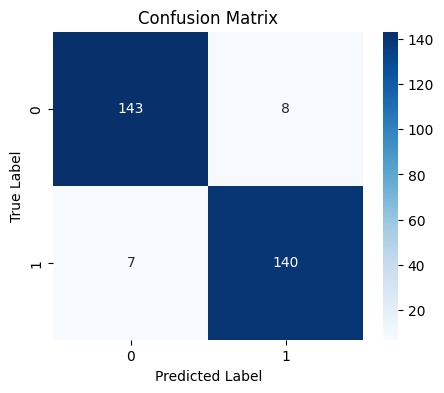

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'y_true' and 'y_pred' contain the true and predicted labels, respectively
cm = confusion_matrix(y_true, y_pred)

# Create the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [10]:

torch.save(model.state_dict(), "/content/model.pt")
